In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import csv
import os

In [2]:
training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [3]:
signs = []
with open('signnames.csv.txt', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [4]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


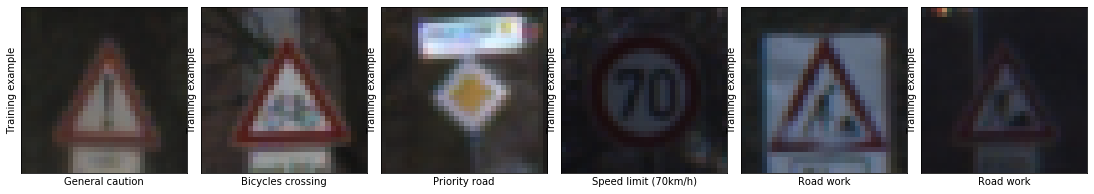

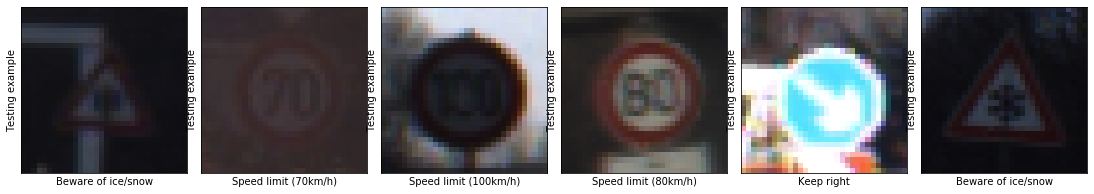

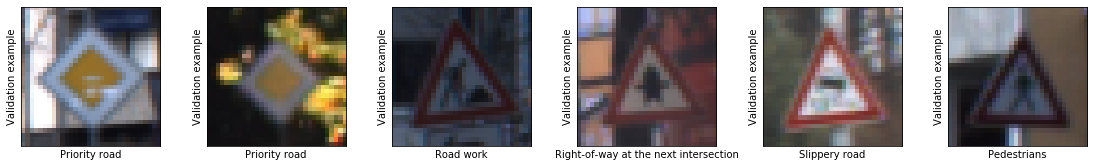

In [5]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

    
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

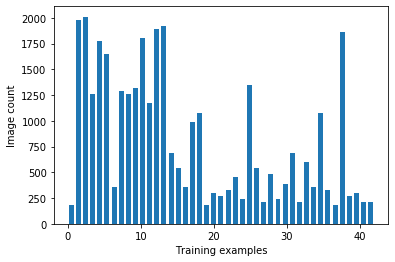

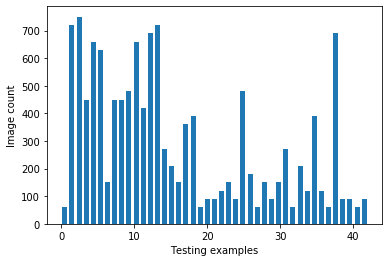

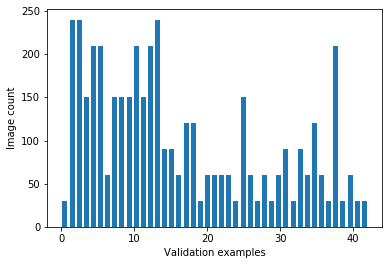

In [6]:
def histogram_plot(dataset, label):
   
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

    
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

In [7]:
import cv2 

def grayscale(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img=cv2.equalizeHist(img)
    return img

def preprocess(img):
    img=grayscale(img)
    img=equalize(img)
    img=img/255
    return img

In [8]:
X_train=np.array(list(map(preprocess,X_train)))
X_test=np.array(list(map(preprocess,X_test)))
X_valid=np.array(list(map(preprocess,X_valid)))

In [9]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(34799, 32, 32)
(12630, 32, 32)
(4410, 32, 32)


In [10]:
X_train=X_train.reshape(34799,32,32,1)
X_test=X_test.reshape(12630,32,32,1)
X_valid=X_valid.reshape(4410,32,32,1)

In [11]:
import keras 
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten,Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [12]:
datagen=ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,
                           zoom_range=0.2,shear_range=0.1,rotation_range=10)
datagen.fit(X_train)

In [13]:
batches=datagen.flow(X_train,y_train,batch_size=15)
X_batch,y_batch=next(batches)


y_train=to_categorical(y_train,43)
y_test=to_categorical(y_test,43)
y_valid=to_categorical(y_valid,43)

In [14]:
def my_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
  
    model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model=my_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

In [16]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data=(X_valid, y_valid), shuffle = 1)


Epoch 1/10
2000/2000 [==============================] - 1105s 552ms/step - loss: 0.8821 - accuracy: 0.7427 - val_loss: 0.0920 - val_accuracy: 0.9739
Epoch 2/10
2000/2000 [==============================] - 809s 405ms/step - loss: 0.2069 - accuracy: 0.9358 - val_loss: 0.0432 - val_accuracy: 0.9875
Epoch 3/10
2000/2000 [==============================] - 795s 398ms/step - loss: 0.1331 - accuracy: 0.9587 - val_loss: 0.0288 - val_accuracy: 0.9925
Epoch 4/10
2000/2000 [==============================] - 798s 399ms/step - loss: 0.1046 - accuracy: 0.9679 - val_loss: 0.0490 - val_accuracy: 0.9871
Epoch 5/10
2000/2000 [==============================] - 792s 396ms/step - loss: 0.0897 - accuracy: 0.9722 - val_loss: 0.0291 - val_accuracy: 0.9916
Epoch 6/10
2000/2000 [==============================] - 739s 370ms/step - loss: 0.0752 - accuracy: 0.9770 - val_loss: 0.0326 - val_accuracy: 0.9907
Epoch 7/10
2000/2000 [==============================] - 741s 370ms/step - loss: 0.0673 - accuracy: 0.9797 - val

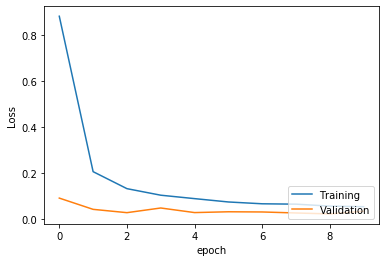

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
 

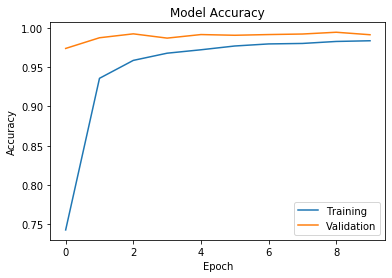

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
 

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13999138573268177
Test accuracy: 0.9699921011924744


(32, 32)
predicted sign: Slippery road


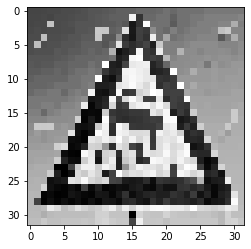

In [44]:
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

k=model.predict_classes(img)[0]
 
print("predicted sign: "+ signs[k])

(32, 32)
predicted sign: Speed limit (30km/h)


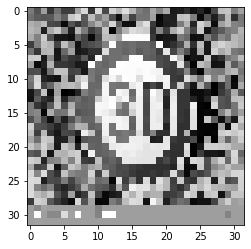

In [45]:
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

k=model.predict_classes(img)[0]
 
print("predicted sign: "+ signs[k])